# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [201]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [287]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[]
[]
[<FluxTable: 12 columns, 603 records>]


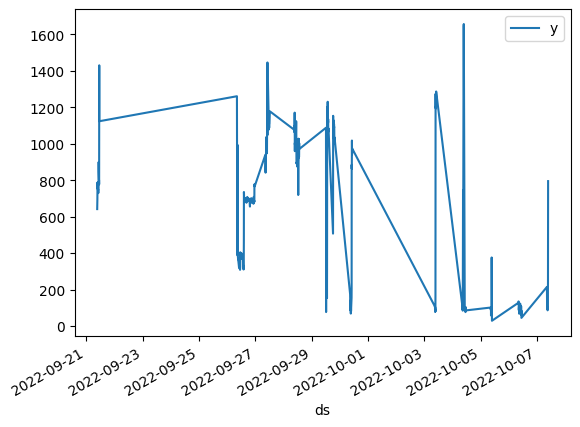

In [289]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-09-03T00:00:00.00Z, stop: 2022-10-07T15:50:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+bucket+ '")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [293]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.60)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.60)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.60)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]

Gas Dataset
   count        mean         std        min         25%         50%  \
y  603.0  636.464572  399.155801  29.333333  310.916667  691.055556   

           75%          max  
y  1001.941758  1656.616667  


### Check if the time-series are stationary using the Dickey-Fuller test

In [294]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

GAS: ADF Statistic: -1.249547
GAS: p-value: 0.651927


### If P Value > 0.05 we go ahead with finding the order of differencing.

GAS: ADF Statistic: -8.841406
GAS: new p-value: 0.000000


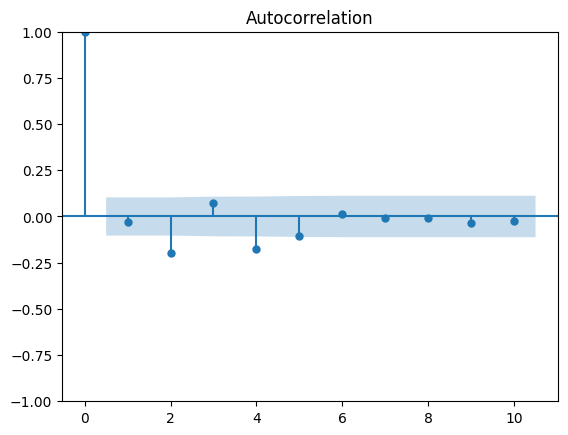

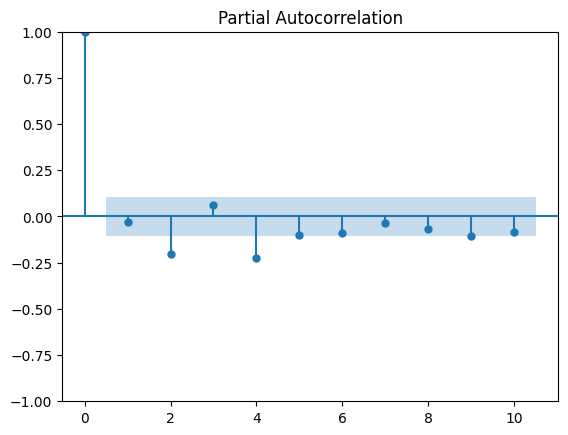

In [295]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty and resultTemp[1] > 0.05):
    train_new = trainTemp.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty and resultHum[1] > 0.05):
    train_new = trainHum.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty and resultGas[1] > 0.05):
    train_new = trainGas.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [297]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))


predicted=917.356913, expected=963.421053
predicted=788.528488, expected=970.750000
predicted=906.162778, expected=154.105263
predicted=108.282369, expected=311.305556
predicted=916.595407, expected=971.541667
predicted=793.176236, expected=1093.600000
predicted=999.444746, expected=1200.000000
predicted=916.954970, expected=1093.187500
predicted=898.873651, expected=1132.166667
predicted=948.303789, expected=1163.344828
predicted=934.858137, expected=1150.296296
predicted=936.273340, expected=1156.181818
predicted=941.684298, expected=1197.440000
predicted=973.350956, expected=1230.361111
predicted=976.159579, expected=1142.000000
predicted=899.403455, expected=1070.230769
predicted=904.738314, expected=1090.193548
predicted=918.072906, expected=1078.285714
predicted=897.531552, expected=1126.937500
predicted=957.599129, expected=1124.130435
predicted=904.968274, expected=1116.222222
predicted=944.181172, expected=1135.562500
predicted=928.196568, expected=1085.687500
predicted=900.10

### ARIMA model evaluation (RMSE)

Test RMSE: 336.335


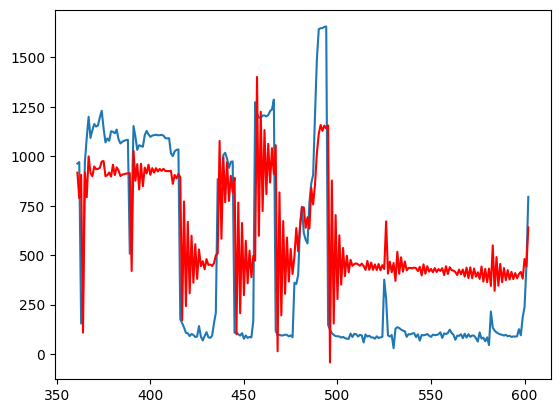

In [298]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df2 = pd. DataFrame (predictionsTemp)
  df2.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df2, color='red')
  plt.show()

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)

  df2 = pd. DataFrame (predictionsHum)
  df2.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df2, color='red')
  plt.show()
if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)

  df2 = pd. DataFrame (predictionsGas)
  df2.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df2, color='red')
  plt.show()